In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mtools import print_each, list_con, save_json

data = pd.read_csv('IGRData/IGR_indoor_230421/origin/point.csv', ',')
data = data.fillna(0)
# print(data)
routes = [data.loc[0:5, ["up","down","left","right"]], data.loc[7:12, ["up","down","left","right"]], data.loc[14:20, ["up","down","left","right"]]]
# print_each(routes)
routes = [route[['up', 'left']].values - route[['down', 'right']].values for route in routes]
# print_each(routes)
routes1 = routes

data = pd.read_csv('IGRData/IGR_indoor_230422/origin/point.csv', ',')
data = data.fillna(0)
# print(data)
inds = [[1,5], [7,12], [14,20], [22, 28], [30, 35], [37, 40], [42, 47]]
# data.loc[0:5, ["up","down","left","right"]], data.loc[6:12, ["up","down","left","right"]], data.loc[13:20, ["up","down","left","right"]]
routes = [data.loc[ind[0]:ind[1], ["x","y"]].values for ind in inds]
# print_each(routes)
routes2 = routes

route_names = ['55_1', '55_2', '55_3', '44_1', '44_2', 'Lib_1', 'Lib_2', 'Dahuo_1', 'Parking_1', 'Classroom_1']
routes = routes1+routes2

/tmp/ipykernel_14852/207689155.py:6: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  data = pd.read_csv('IGRData/IGR_indoor_230421/origin/point.csv', ',')
/tmp/ipykernel_14852/207689155.py:15: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  data = pd.read_csv('IGRData/IGR_indoor_230422/origin/point.csv', ',')


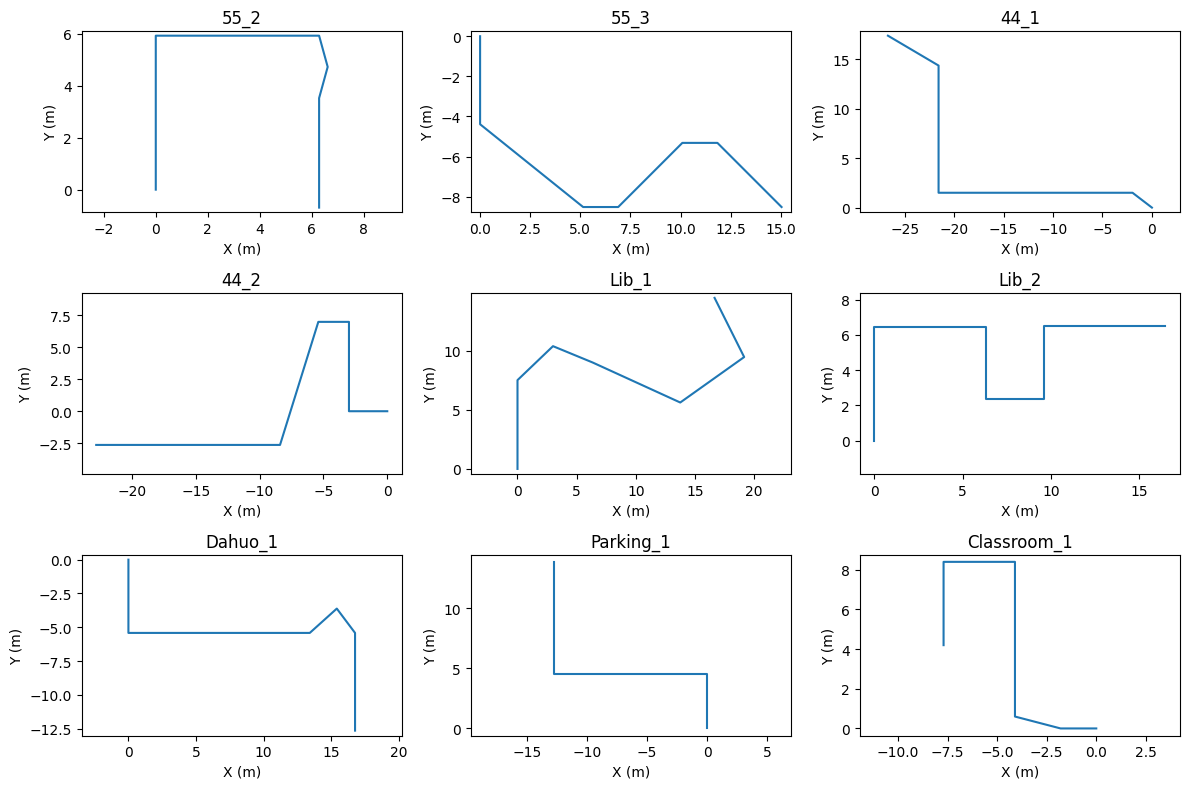

In [3]:
def rotate_locations(locations, angle):
    rotate_matrix = np.array([[np.cos(angle),-np.sin(angle)],[np.sin(angle),np.cos(angle)]])
    return np.dot(locations, rotate_matrix)

rotate_degs = [90, 90, 90, 
               0, 0, 0,
               0, 90, 0,
               0, 0, 0]
rotate_degs = np.array(rotate_degs).astype('float')*np.pi/180
cdns_list = []

fig, axs = plt.subplots(3, 3, figsize=(12, 8))
axs = list_con(axs)
for route,ax,rotate_deg,route_name in zip(routes[1:], axs, rotate_degs[1:], route_names[1:]):
# for route,ax,rotate_deg,route_name in zip(routes, axs, rotate_degs, route_names):
    cdns = np.cumsum(route, axis=0)
    cdns = rotate_locations(cdns, rotate_deg)
    cdns_list.append(cdns)
    ax.plot(cdns[:, 0], cdns[:, 1], label="Ground Truth")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.axis('equal')
    ax.set_title(route_name)
    fig.tight_layout()

route_dict = dict(zip(route_names[1:], [cdns.tolist() for cdns in cdns_list]))
# save_json(f'IGRProcessed_old/Indoor_paths/04-21_22.json', route_dict)

# python gen_route_name_dict.py

In [4]:
def get_marks(markdata):
    s = markdata['x'] == 'x'
    xrows = s.loc[s].index.values
    sinds = (xrows+1).tolist()
    einds = (xrows[1:]-1).tolist() + [s.shape[0]-1]
    inds = list(zip(sinds, einds))
    marks = [markdata.loc[ind[0]:ind[1], ["pid", "x", "y"]].values.astype('float') for ind in inds]
    return marks

def get_mark_cdns(route, mark):
    cdns = np.cumsum(route, axis=0)
    return np.vstack([cdns[int(_[0])]+_[1:] for _ in mark])

/tmp/ipykernel_14852/1248281918.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  markdata1 = pd.read_csv('IGRData/IGR_indoor_230421/origin/mark.csv', ',')
/tmp/ipykernel_14852/1248281918.py:2: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  markdata2 = pd.read_csv('IGRData/IGR_indoor_230422/origin/mark.csv', ',')


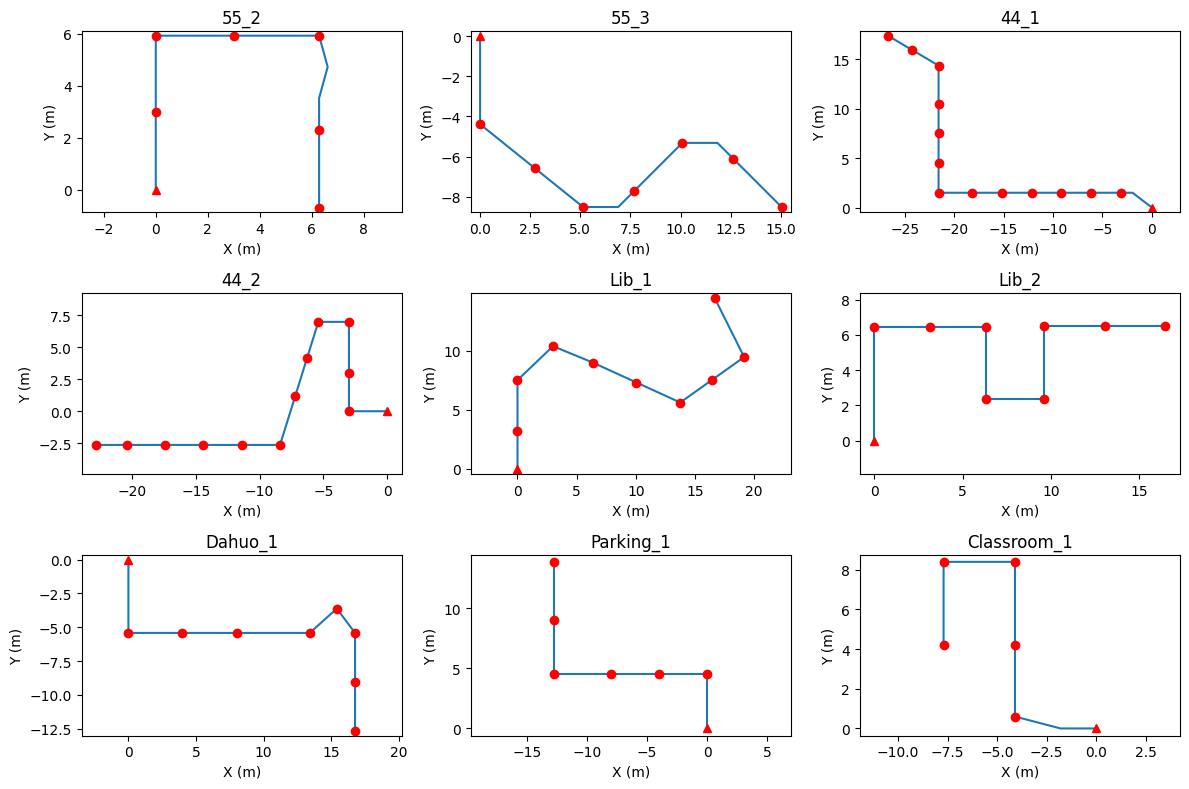

In [6]:
markdata1 = pd.read_csv('IGRData/IGR_indoor_230421/origin/mark.csv', ',')
markdata2 = pd.read_csv('IGRData/IGR_indoor_230422/origin/mark.csv', ',')

marks1 = get_marks(markdata1)
marks2 = get_marks(markdata2)
marks = marks1+marks2

mark_cdns = [rotate_locations(get_mark_cdns(route, mark), rotate_deg) for route, rotate_deg, mark in zip(routes, rotate_degs, marks)]
new_mark_cdns = []
fig, axs = plt.subplots(3, 3, figsize=(12, 8))
axs = list_con(axs)

for route,ax,rotate_deg,route_name,mark_cdn in zip(routes[1:], axs, rotate_degs[1:], route_names[1:], mark_cdns[1:]):
# for route,ax,rotate_deg,route_name in zip(routes, axs, rotate_degs, route_names):
    cdns = np.cumsum(route, axis=0)
    cdns = rotate_locations(cdns, rotate_deg)
    ax.plot(cdns[:, 0], cdns[:, 1], label="Ground Truth")
    ax.plot(mark_cdn[1:, 0], mark_cdn[1:, 1], 'ro', label="Mark")
    ax.plot(mark_cdn[0, 0], mark_cdn[0, 1], 'r^', label="Start")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.axis('equal')
    ax.set_title(route_name)
    fig.tight_layout()

mark_dict = dict(zip(route_names[1:], [cdns.tolist() for cdns in mark_cdns[1:]]))
save_json(f'IGRProcessed_old/Indoor_paths/04-21_22_mark.json', mark_dict)

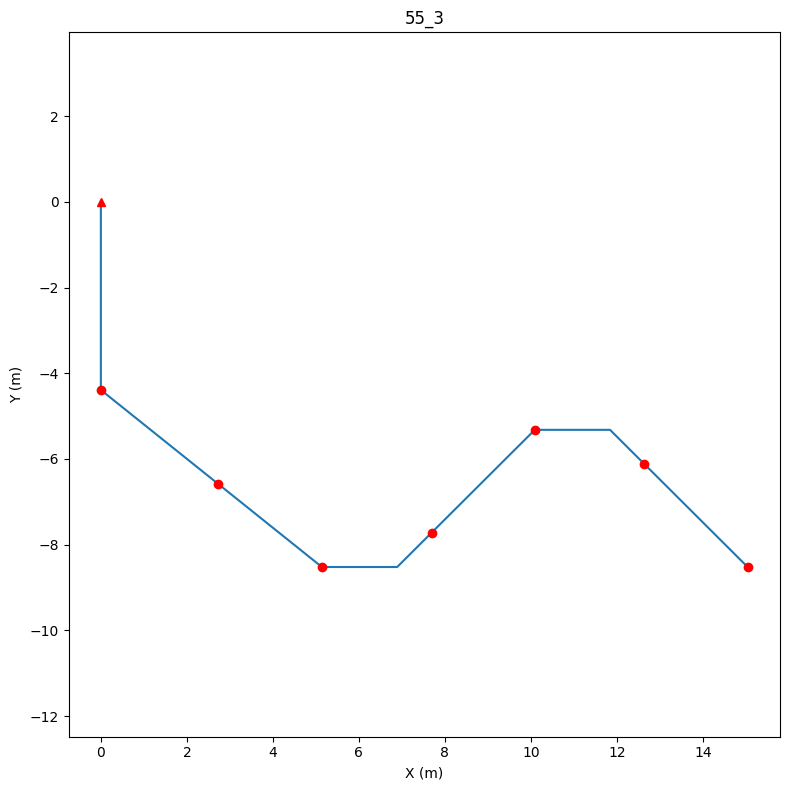

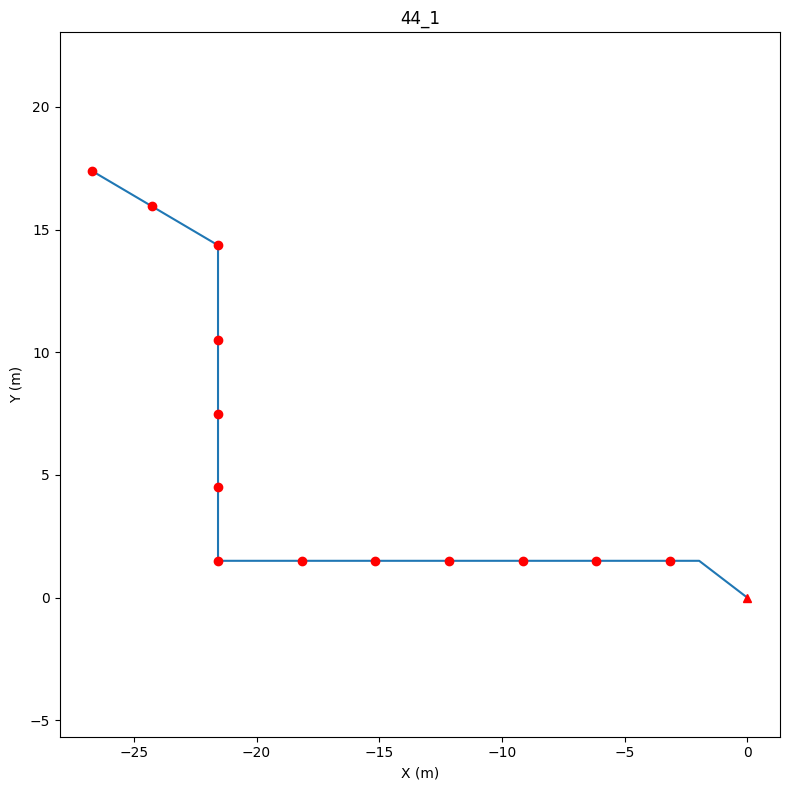

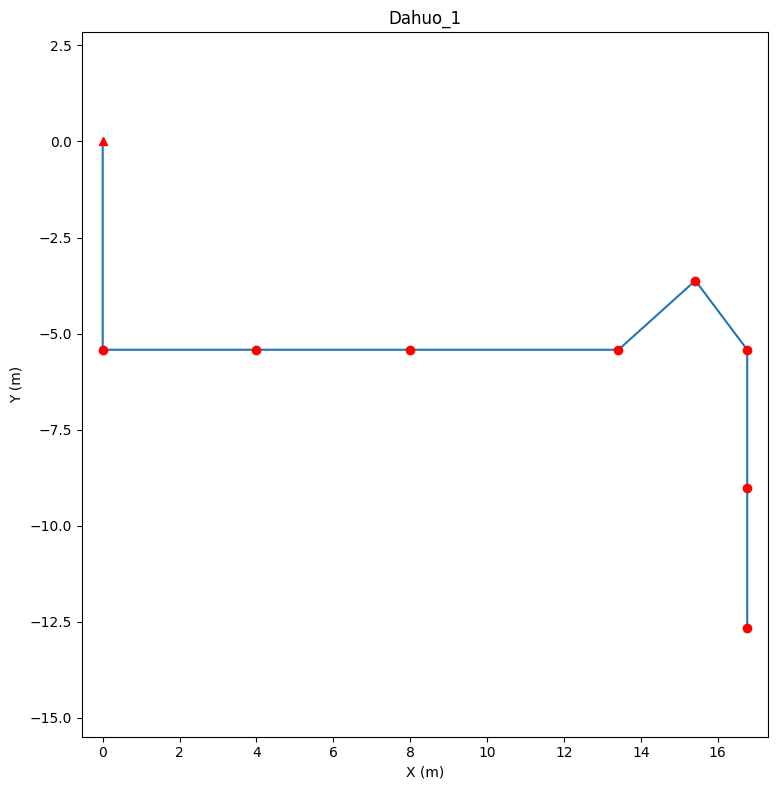

In [13]:
plot_ind = [2,3,7]
from mtools import list_ind
for route,rotate_deg,route_name,mark_cdn in zip(list_ind(routes, plot_ind), list_ind(rotate_degs, plot_ind), list_ind(route_names, plot_ind), list_ind(mark_cdns, plot_ind)):
    fig = plt.figure(figsize=(8  , 8))
    ax = fig.add_subplot(1,1,1)
    cdns = np.cumsum(route, axis=0)
    cdns = rotate_locations(cdns, rotate_deg)
    ax.plot(cdns[:, 0], cdns[:, 1], label="Ground Truth")
    ax.plot(mark_cdn[1:, 0], mark_cdn[1:, 1], 'ro', label="Mark")
    ax.plot(mark_cdn[0, 0], mark_cdn[0, 1], 'r^', label="Start")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.axis('equal')
    ax.set_title(route_name)
    plt.tight_layout()

mark_dict = dict(zip(route_names[1:], [cdns.tolist() for cdns in mark_cdns[1:]]))
# save_json(f'IGRProcessed/Indoor_paths/04-21_22_mark.json', mark_dict)

In [13]:
i = 2
print(np.round(mark_cdns[i], 2))
print(np.round(mark_cdns[i][1:]-mark_cdns[i][:-1], 2))

[[ 0.    0.  ]
 [ 0.   -4.39]
 [ 2.72 -6.58]
 [ 5.14 -8.52]
 [ 7.69 -7.72]
 [10.09 -5.32]
 [12.64 -6.12]
 [15.04 -8.52]]
[[ 0.   -4.39]
 [ 2.72 -2.19]
 [ 2.42 -1.94]
 [ 2.55  0.8 ]
 [ 2.4   2.4 ]
 [ 2.55 -0.8 ]
 [ 2.4  -2.4 ]]


In [14]:
i = 3
print(np.round(mark_cdns[i], 2))
print(np.round(mark_cdns[i][1:]-mark_cdns[i][:-1], 2))

[[  0.     0.  ]
 [ -3.16   1.5 ]
 [ -6.16   1.5 ]
 [ -9.16   1.5 ]
 [-12.16   1.5 ]
 [-15.16   1.5 ]
 [-18.16   1.5 ]
 [-21.57   1.5 ]
 [-21.57   4.5 ]
 [-21.57   7.5 ]
 [-21.57  10.5 ]
 [-21.57  14.36]
 [-24.27  15.96]
 [-26.69  17.38]]
[[-3.16  1.5 ]
 [-3.    0.  ]
 [-3.    0.  ]
 [-3.    0.  ]
 [-3.    0.  ]
 [-3.    0.  ]
 [-3.41  0.  ]
 [ 0.    3.  ]
 [ 0.    3.  ]
 [ 0.    3.  ]
 [ 0.    3.86]
 [-2.7   1.6 ]
 [-2.42  1.42]]


In [15]:
i = 7
print(np.round(mark_cdns[i], 2))
print(np.round(mark_cdns[i][1:]-mark_cdns[i][:-1], 2))

[[  0.     0.  ]
 [  0.    -5.42]
 [  4.    -5.42]
 [  8.    -5.42]
 [ 13.42  -5.42]
 [ 15.42  -3.62]
 [ 16.77  -5.42]
 [ 16.77  -9.03]
 [ 16.77 -12.65]]
[[ 0.   -5.42]
 [ 4.    0.  ]
 [ 4.    0.  ]
 [ 5.42  0.  ]
 [ 2.    1.8 ]
 [ 1.35 -1.8 ]
 [ 0.   -3.61]
 [ 0.   -3.62]]
